In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC

In [2]:
pd.set_option('display.expand_frame_repr', False)
spoty_df = pd.read_csv('SpotifyFeatures.csv')

spoty_df = shuffle(spoty_df)

FileNotFoundError: [Errno 2] No such file or directory: 'SpotifyFeatures.csv'

### Dataset structure

In [ ]:
print(spoty_df.head())
print(spoty_df.describe())
print(spoty_df.info())
print(spoty_df['genre'])

             genre     artist_name                 track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
188480         Ska        Catch 22     San Francisco Payphone  1v5FiXPXTyIIOGxfAjmRAi          19       0.06150         0.401       169640   0.823          0.000000   A    0.0728    -4.972  Major       0.0743  106.446            4/4    0.879
14700        Dance  The Raconteurs        Steady, As She Goes  19iqWNzp5LwEdvntpEK8MP          65       0.01320         0.524       215267   0.578          0.009210   A    0.1080    -4.563  Major       0.1200  123.669            4/4    0.537
24123   Electronic     Stereo MC's                  Connected  71YR4tmVuNimv51JcWEkcI          40       0.05190         0.659       313000   0.818          0.000972  C#    0.1070   -10.699  Minor       0.0364  100.678            4/4    0.704
48547        Blues      John Fah

### management of null, infinite and duplicate values

In [ ]:
#checking null values
null_values = spoty_df.isnull()
null_columns = null_values.any()
print("Colonne con valori nulli:")
print(null_columns)

Colonne con valori nulli:
genre               False
artist_name         False
track_name           True
track_id            False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
dtype: bool


In [ ]:
#checking infinite values
if spoty_df.select_dtypes(include=[np.number]).applymap(np.isinf).any().any():
    print("Sono presenti valori infiniti nel DataFrame.")
else:
    print("Non sono presenti valori infiniti nel DataFrame.")

Non sono presenti valori infiniti nel DataFrame.


In [ ]:
#checking and removing duplicates
duplicates = spoty_df[spoty_df.duplicated(subset=['track_id'])]
print("duplicates:")
print(duplicates)
spoty_df = spoty_df.drop_duplicates(subset=['track_id'])
genre_counts = spoty_df['genre'].value_counts()
print(genre_counts)

duplicates:
        genre               artist_name                                track_name                track_id  popularity  acousticness  danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  speechiness    tempo time_signature  valence
21085   Dance                The Cramps                                 Human Fly  0ElRzK07sc9eszyk1ea9Ab          53        0.0389         0.531       136427  0.8490          0.007630   A    0.1860   -10.754  Major       0.1110  119.516            4/4   0.3050
192336   Soul                Amber Mark                              Lose My Cool  3G9zeErd0kMx012kmYUrm7          66        0.5790         0.733       214578  0.4740          0.000272  D#    0.0870    -8.024  Major       0.0439  102.976            4/4   0.3280
110244    Pop              Taylor Swift               Dancing With Our Hands Tied  7I7JbDv63ZJJsSi24DyJrz          68        0.0604         0.624       211507  0.6910          0.000011   C    0.1380    

### Selection of genres and elimination of uninteresting features

In [ ]:
#Selection of the genres of interest.
desired_genres = ['Rock', 'Classical', 'Jazz']
top3_df = spoty_df[spoty_df['genre'].isin(desired_genres)]
genre_counts = top3_df['genre'].value_counts()
print(genre_counts)

genre
Classical    8624
Jazz         8252
Rock         4572
Name: count, dtype: int64


In [ ]:
#Elimination of features that are certainly useless.
top3_df = top3_df.drop(['artist_name'], axis=1)
top3_df = top3_df.drop(['track_name'], axis=1)
top3_df = top3_df.drop(['track_id'], axis=1)
top3_df = top3_df.drop(['duration_ms'], axis=1)

# EDA

In [ ]:
# Selection of only the numerical columns.
features = top3_df.select_dtypes(include=np.number).columns.tolist()

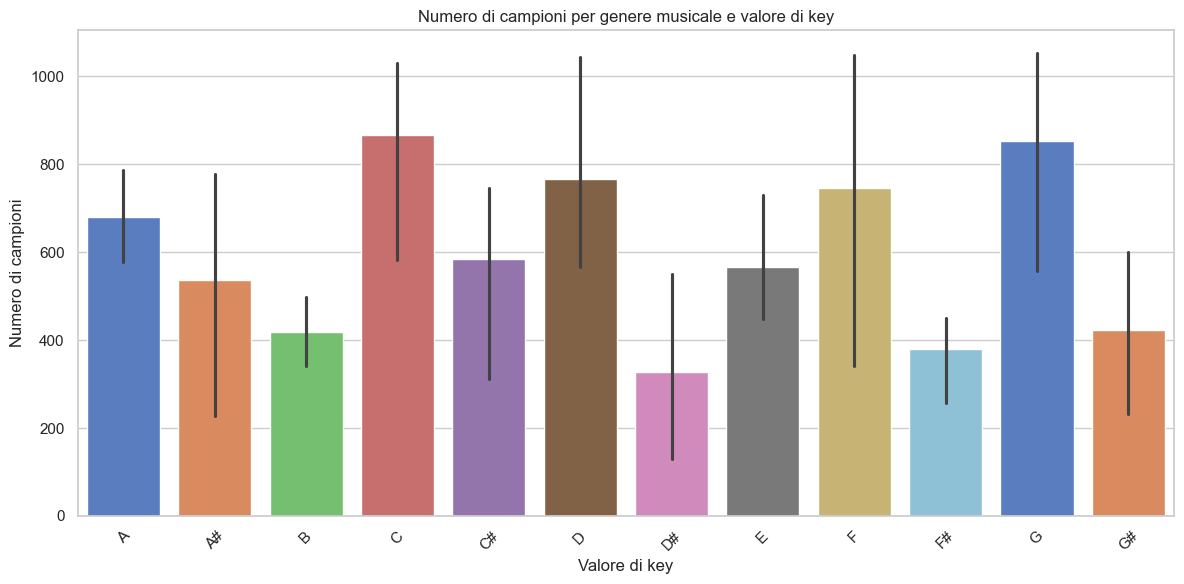

In [ ]:
grouped = top3_df.groupby(['genre', 'key']).size().unstack(fill_value=0)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, palette="muted")
plt.xlabel('Valore di key')
plt.ylabel('Numero di campioni')
plt.title('Numero di campioni per genere musicale e valore di key')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Handling of time_signature

In [ ]:
print(top3_df['time_signature'].unique())
#It is very likely that the entry of 1/4 is a data entry error because it is equivalent to 4/4.
top3_df.loc[:, 'time_signature'] = top3_df['time_signature'].replace(['1/4'], '4/4')
print("Tracks with a 0/4 time signature: %s" % len(top3_df[top3_df['time_signature'] == '0/4']))
top3_df = top3_df[top3_df['time_signature'] != '0/4']  # Remove the rows with '0/4' from the 'time_signature' column.

['4/4' '3/4' '5/4' '1/4']
Tracks with a 0/4 time signature: 0


### Genre distribution

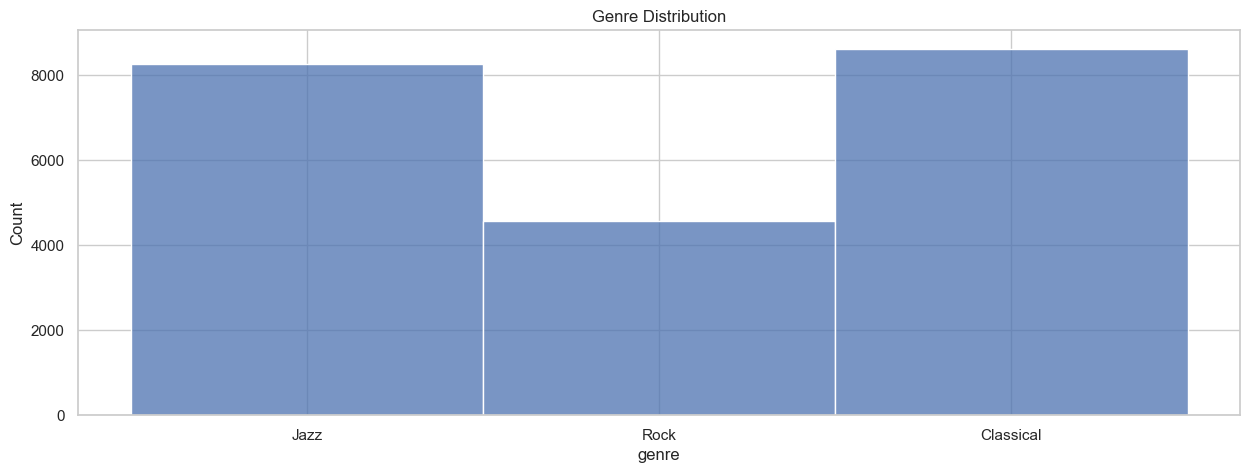

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(top3_df['genre']).set_title('Genre Distribution')
plt.show()

In [ ]:
# We notice that the dataset is unbalanced.

## Conversion of categorical values

In [ ]:
#We use labels because they are ordinal categorical values
time_signature_mapping = {'3/4': 0,'4/4':1 ,'5/4': 2}
top3_encoded_df=top3_df
top3_encoded_df['time_signature'] = top3_encoded_df['time_signature'].map(time_signature_mapping)
mode_mapping = {'Major': 1,'Minor':0}
top3_encoded_df['mode'] = top3_encoded_df['mode'].map(mode_mapping)
notes_ordered = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
key_mapping = {note: index for index, note in enumerate(notes_ordered)}
top3_encoded_df['key'] = top3_encoded_df['key'].map(key_mapping)
print(top3_df.head())

            genre  popularity  acousticness  danceability  energy  instrumentalness  key  liveness  loudness  mode  speechiness    tempo  time_signature  valence
180867       Jazz          37       0.57700         0.829   0.747          0.000009    1    0.2140    -6.605     0       0.2660   89.820               1   0.5290
224208       Rock          58       0.05200         0.528   0.856          0.000000    7    0.0988    -4.605     1       0.0351   87.019               1   0.5720
176938       Jazz          32       0.74500         0.599   0.384          0.395000    0    0.0864   -11.478     1       0.0293  119.901               1   0.2660
124656  Classical          15       0.92700         0.229   0.181          0.881000    1    0.1710   -14.792     1       0.0352  106.933               1   0.0473
166360       Rock          75       0.00178         0.394   0.944          0.000005   10    0.2980    -6.506     0       0.0761  105.338               1   0.2650


## Normalization

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

top3_encoded_df['loudness'] *= -1

# Splitting labels from features
t = top3_encoded_df['genre']
X = top3_encoded_df.drop(['genre'], axis=1)

# Splitting the dataset in train and test
X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

#Merging X_train and X_test, t_train and t_test into a single DataFrame
X_combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

t_train = pd.DataFrame(t_train).reset_index(drop=True)
t_test = pd.DataFrame(t_test).reset_index(drop=True)

X_train['genre'] = t_train
X_test['genre'] = t_test

df_with_labels = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

#final dataframe
print("\ncombined_df_with_labels:")
print(df_with_labels)



combined_df_with_labels:
       popularity  acousticness  danceability    energy  instrumentalness       key  liveness  loudness      mode  speechiness     tempo  time_signature   valence      genre
0        1.639346     -1.507713      0.120505  0.804768         -0.988940 -1.484916 -0.629565 -1.011348  0.759275    -0.463348  1.079420        0.308111 -0.800383       Rock
1        0.766171      0.879504      0.379194 -0.435891         -0.988933 -1.484916 -0.525440 -0.561684  0.759275    -0.380311 -1.270474        0.308111 -0.394536       Rock
2        1.265128      0.158508      1.957193  0.487933         -0.988940  0.823839 -0.733013 -0.599825  0.759275    -0.217627  0.620329        0.308111  2.110649       Rock
3       -0.418853      0.361932      1.082826  0.624673         -0.534975  0.535244 -0.583588 -0.829875 -1.317045    -0.498936 -1.076073        0.308111  0.730768       Jazz
4       -0.605962      0.125033      0.715489  0.527955          1.084911  0.535244 -0.665400 -0.453136 

## Further data exploration

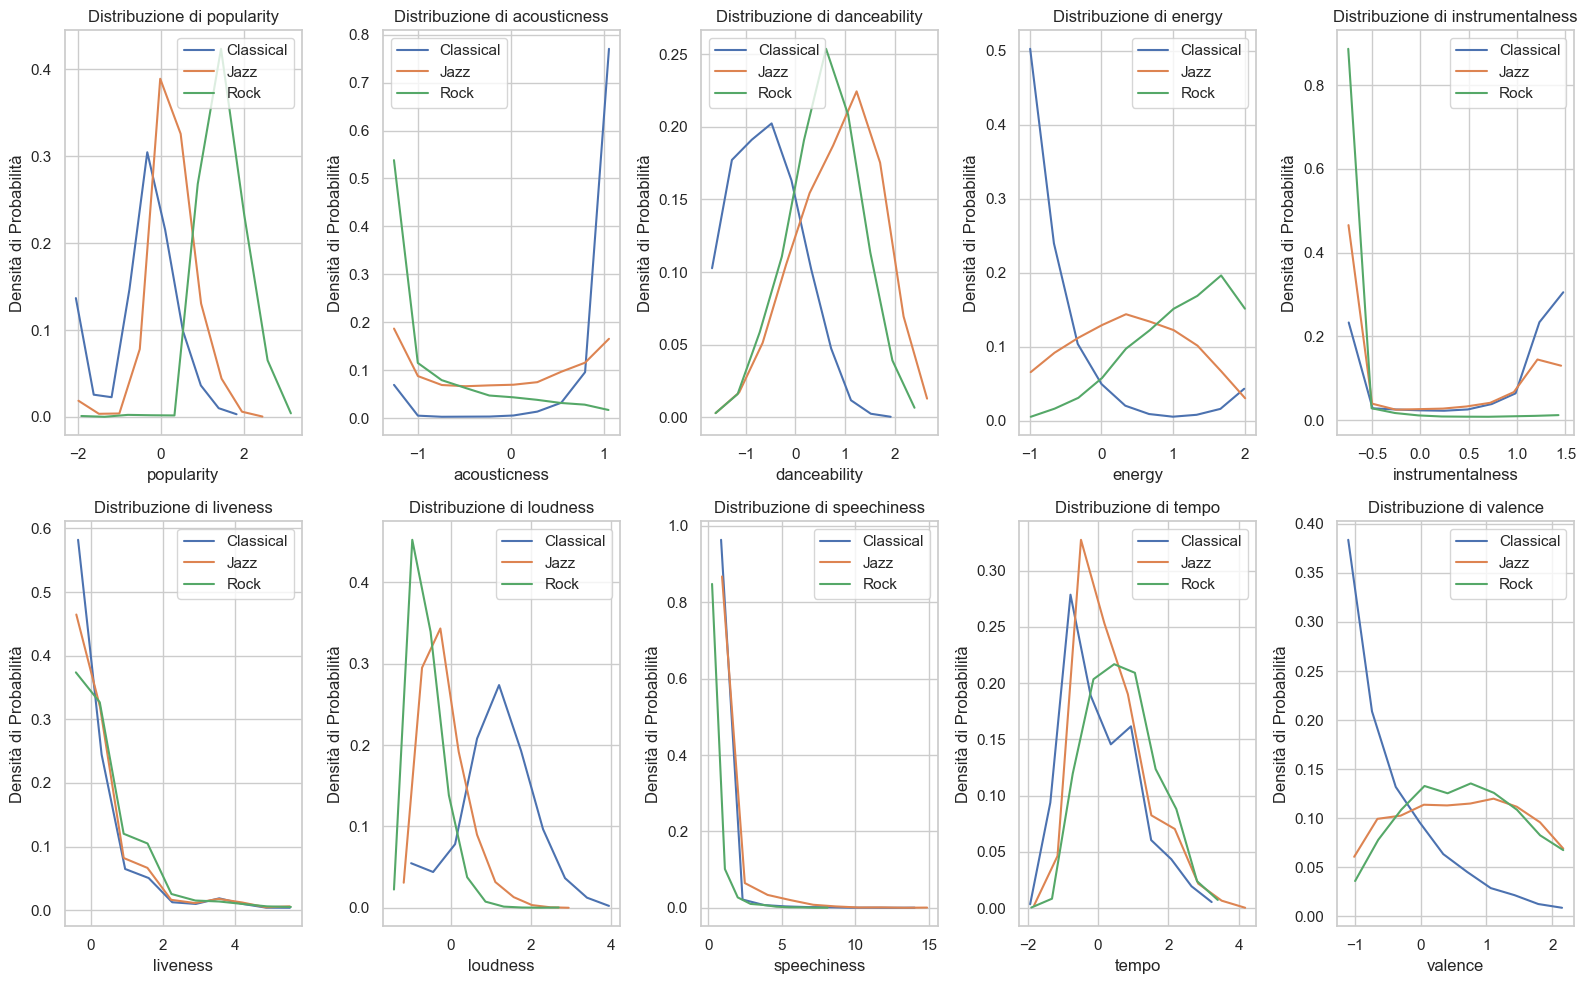

In [ ]:
num_rows = 2
num_cols = (len(features) + 1) // 2
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features, start=1):
    plt.subplot(num_rows, num_cols, i)

    for genre, data in df_with_labels.groupby('genre'):
        counts, bin_edges = np.histogram(data[feature], bins=10, density=True)
        pdf = counts / sum(counts)

        plt.plot(bin_edges[1:], pdf, label=genre)

    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densità di Probabilità')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#We might consider dropping tempo, speechiness, liveness, and instrumentalness since their distributions are largely
#overlapping and thus not sufficiently discriminating.

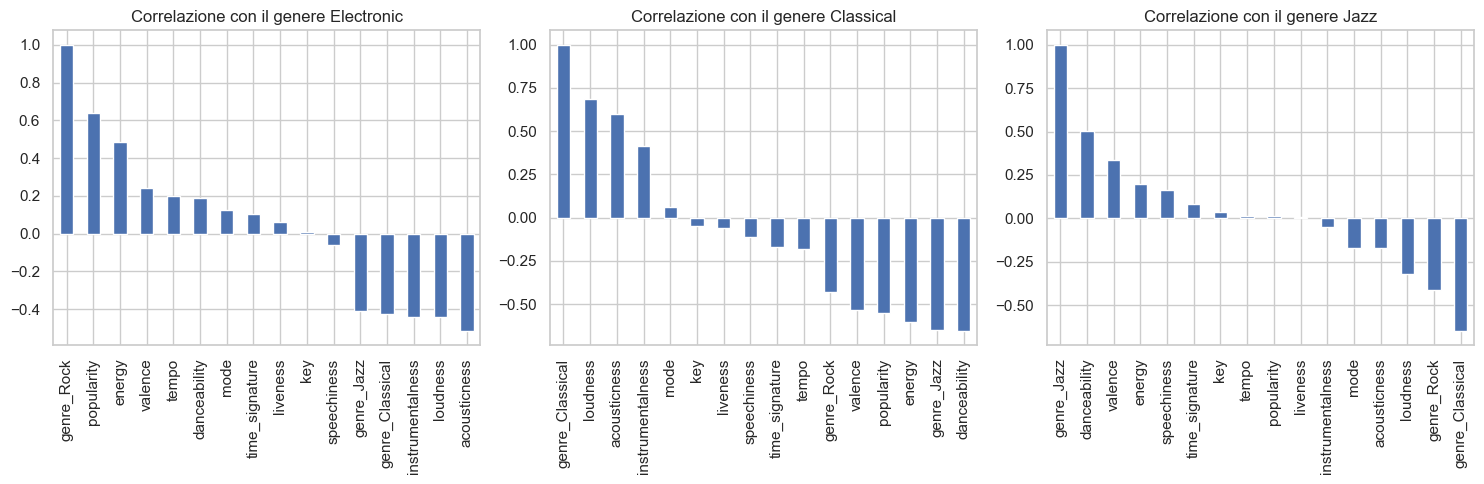

In [ ]:
#Let's try to understand which features better explain the genres.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
X_dummies=pd.get_dummies(df_with_labels)
X_dummies.corr()['genre_Rock'].sort_values(ascending=False).plot(kind='bar', ax=axs[0])
axs[0].set_title('Correlazione con il genere Electronic')
X_dummies.corr()['genre_Classical'].sort_values(ascending=False).plot(kind='bar', ax=axs[1])
axs[1].set_title('Correlazione con il genere Classical')
X_dummies.corr()['genre_Jazz'].sort_values(ascending=False).plot(kind='bar', ax=axs[2])
axs[2].set_title('Correlazione con il genere Jazz')
plt.tight_layout()
plt.show()

In [ ]:
#The result of the previous graph is confirmed by this graph. We also notice that key doesn't explain well enough the genre.

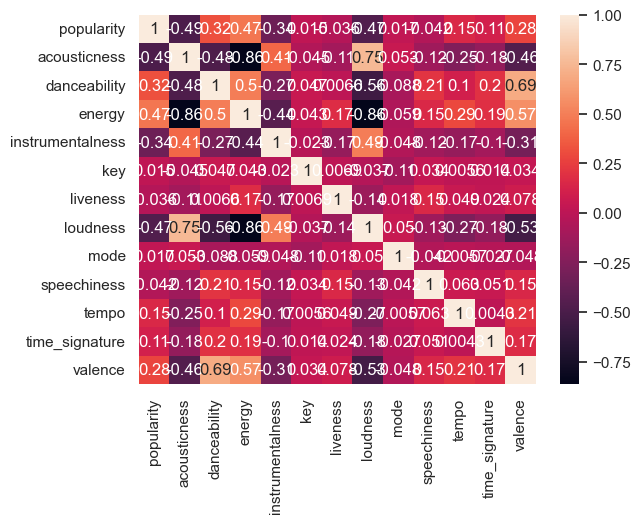

In [ ]:
#Analysis of the correlation between features
corr_matrix = df_with_labels.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
#We notice that energy is highly correlated with acousticness, and we might consider dropping one of them.

In [ ]:
df_with_labels=df_with_labels.reset_index(drop=True).drop(columns=['key','instrumentalness','speechiness','liveness','tempo','time_signature'], axis=1)


#top5_encoded_df.drop('energy', axis=1)


# Outlier management

C:\Users\Alessandra\AppData\Local\Temp\ipykernel_13644\21306688.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_with_labels.drop(['genre'], axis=1).columns, rotation=45)  # Imposta i nomi delle colonne come etichette sull'asse x


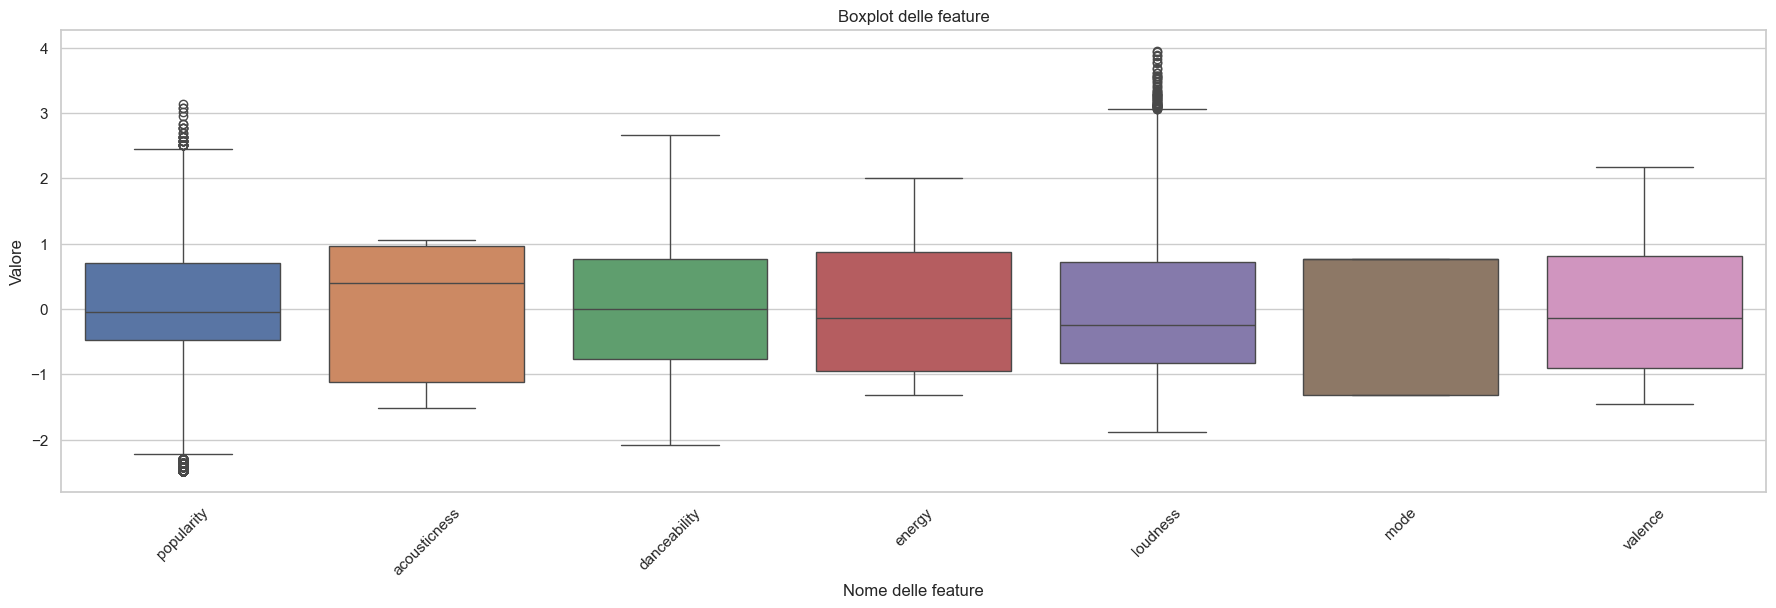

In [ ]:
#grafico box per controllare outlier
plt.figure(figsize=(22, 6))
ax = sns.boxplot(data=df_with_labels.drop(['genre'], axis=1).values)
ax.set_xticklabels(df_with_labels.drop(['genre'], axis=1).columns, rotation=45)  # Imposta i nomi delle colonne come etichette sull'asse x
plt.xlabel('Nome delle feature')  # Aggiungi un'etichetta all'asse x
plt.ylabel('Valore')  # Aggiungi un'etichetta all'asse y
plt.title('Boxplot delle feature')  # Aggiungi un titolo al grafico
plt.show()

#print(X_train.head())
#mi concentro sulle feature 5,6,8 che sono quelle con outlier (tempo, liveness, loudaness e  speechiness)

In [ ]:
#Splitting into train and test to remove outliers only from train
t = df_with_labels['genre']
X = df_with_labels.drop(['genre'], axis=1)

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size=0.7, test_size=0.3, random_state=100)

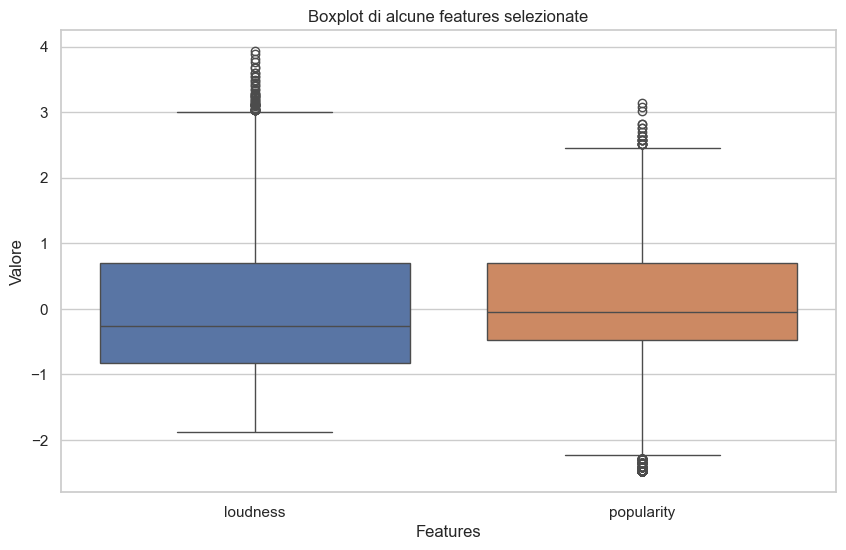

In [ ]:
selected_columns = X_train[[ 'loudness','popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()

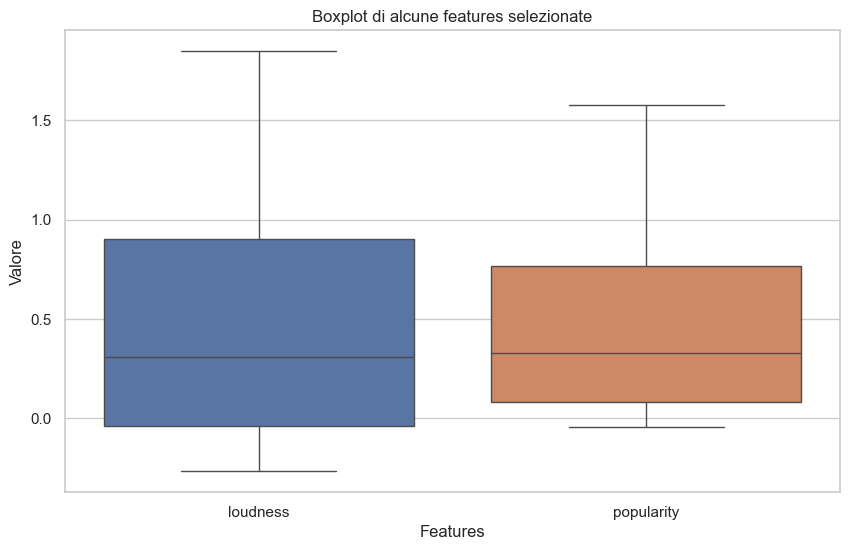

In [ ]:
# Removing outliers from X_train and corresponding records from y_train
quantiles = X_train[['loudness','popularity']].quantile([0.5, 0.95])
lower_quantile = quantiles.iloc[0]
upper_quantile = quantiles.iloc[1]

X_train = X_train[(X_train['loudness'] >= lower_quantile['loudness']) & (X_train['loudness'] <= upper_quantile['loudness'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

X_train = X_train[(X_train['popularity'] >= lower_quantile['popularity']) & (X_train['popularity'] <= upper_quantile['popularity'])]
t_train = t_train[X_train.index]  # Elimina i record corrispondenti da t_train

# Graph without outliers
selected_columns = X_train[['loudness', 'popularity']]
selected_data = pd.DataFrame(selected_columns)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=selected_data)
plt.xlabel('Features')
plt.ylabel('Valore')
plt.title('Boxplot di alcune features selezionate')
plt.show()


## VIF

In [ ]:
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)


        Feature   VIF
3        energy  7.10
4      loudness  3.45
1  acousticness  3.32
6       valence  2.36
2  danceability  2.08
0    popularity  1.44
5          mode  1.01


In [ ]:
# we notice we could drop energy

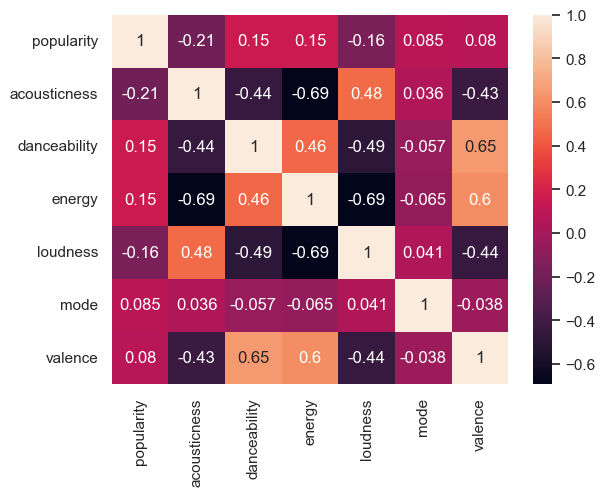

In [ ]:
#Let's check if the correlation matrix gives us the same result
corr_matrix = X_train.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()
# we can definetly drop energy

In [ ]:
X_train.drop('energy', axis=1, inplace=True)
X_test.drop('energy', axis=1, inplace=True)
vif = pd.DataFrame()
column_names = pd.get_dummies(X_train, drop_first='False').columns.tolist()
vif['Feature'] = column_names
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
print(vif)

        Feature   VIF
3      loudness  2.18
1  acousticness  2.05
5       valence  2.05
2  danceability  1.99
0    popularity  1.24
4          mode  1.01


# logistic regression

In [ ]:
hyper_param = [
    {
        'C': np.logspace(-4, 4, 20),
        'solver': ['lbfgs','newton-cg', 'sag', 'saga'],
        'max_iter': [100, 1000, 2500]
    }
]

# Model creation and training using grid search
clf = GridSearchCV(linear_model.LogisticRegression(multi_class='multinomial'), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_weighted')
best_clf = clf.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clf.best_params_)
print("F1 score on the train set: ", clf.best_score_)

# Training the best model on the complete training data
best_model = linear_model.LogisticRegression(**clf.best_params_)
best_model.fit(X_train, t_train)

# Prediction on the test set
t_hat_test = best_model.predict(X_test)

# Calculation of evaluation metrics on the test set
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))
print(classification_report(t_test, t_hat_test))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Tuned hyperparameters (best parameters):  {'C': 1.623776739188721, 'max_iter': 100, 'solver': 'lbfgs'}
F1 score on the train set:  0.7910507864421111
Accuracy score on the test set:  0.8621600621600621
F1 score on the test set:  0.8627007025526234
              precision    recall  f1-score   support

   Classical       0.93      0.83      0.88      2660
        Jazz       0.81      0.86      0.83      2417
        Rock       0.84      0.92      0.88      1358

    accuracy                           0.86      6435
   macro avg       0.86      0.87      0.86      6435
weighted avg       0.87      0.86      0.86      6435



## Confusion matrix

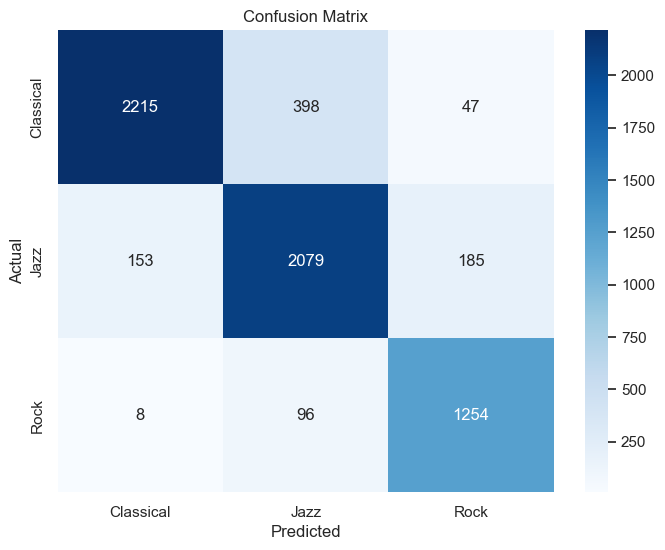

In [ ]:
conf_matrix = confusion_matrix(t_test, t_hat_test)

labels = ['Classical', 'Jazz','Rock']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [ ]:
hyper_param = [
    {
        'n_neighbors': [3, 7,9,11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
]

clfKNN = GridSearchCV(KNeighborsClassifier(), param_grid=hyper_param, verbose=10, n_jobs=-1, error_score="raise",scoring='f1_macro')
best_clf = clfKNN.fit(X_train, t_train)

# Printing the best parameters and the best accuracy
print("Tuned hyperparameters (best parameters): ", clfKNN.best_params_)
print("Accuracy:", clfKNN.best_score_)

t_hat_test = clfKNN.predict(X_test)
print("Accuracy score on the test set: ", accuracy_score(t_test, t_hat_test))
print("F1 score on the test set: ", f1_score(t_test, t_hat_test, average='weighted'))


# Training the best model on the complete training data
model = KNeighborsClassifier(**clfKNN.best_params_)
model.fit(X_train, t_train)

# Prediction on the test set
t_pred = model.predict(X_test)

# Calculation of evaluation metrics on the test set
print(classification_report(t_test, t_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Tuned hyperparameters (best parameters):  {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.7554268024167806
Accuracy score on the test set:  0.8222222222222222
F1 score on the test set:  0.8235877812081827
              precision    recall  f1-score   support

   Classical       0.94      0.76      0.84      2660
        Jazz       0.74      0.87      0.80      2417
        Rock       0.81      0.85      0.83      1358

    accuracy                           0.82      6435
   macro avg       0.83      0.83      0.82      6435
weighted avg       0.84      0.82      0.82      6435



## ROC-AUC

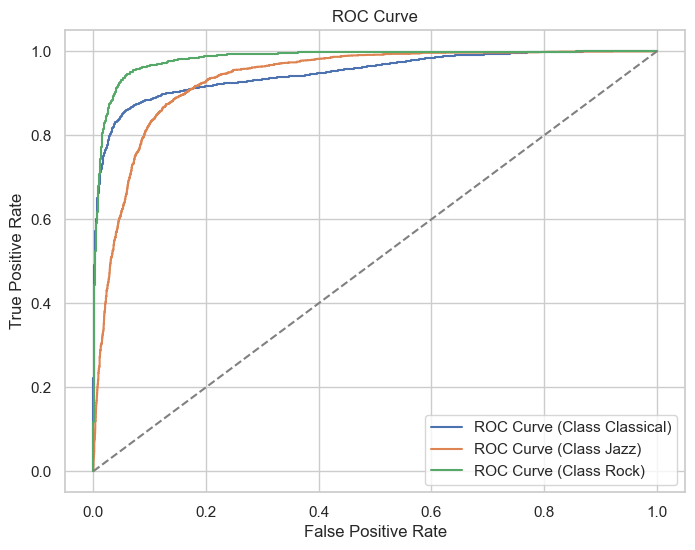

In [ ]:
# Calculate the class probabilities for the test set
probs = clf.predict_proba(X_test)

# Calculate the ROC-AUC for each class
roc_auc = roc_auc_score(t_test, probs, multi_class='ovr')  # 'ovr' for multiclass problems

#Calculate and plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(t_test == labels[i], probs[:, i])
    plt.plot(fpr, tpr, label=f'ROC Curve (Class {labels[i]})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network

In [ ]:
print(t_train)

9139          Jazz
10383         Jazz
14971    Classical
17666         Jazz
12869         Rock
           ...    
12219         Jazz
10843    Classical
15453    Classical
13890    Classical
5640          Jazz
Name: genre, Length: 2162, dtype: object


In [ ]:
hyper_param_mlp = {
    'hidden_layer_sizes': [(100,100), (100, 150), (150, 150)],
    'activation': [ 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True, False],
    'max_iter': [500]
}

clfMLP = GridSearchCV(MLPClassifier(), param_grid=hyper_param_mlp, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_mlp = clfMLP.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clfMLP.best_params_)
print("Accuracy:", clfMLP.best_score_)

best_mlp_model = MLPClassifier(**clfMLP.best_params_)
best_mlp_model.fit(X_train, t_train)

t_hat_test_mlp = best_mlp_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_hat_test_mlp, average='weighted'))

print(classification_report(t_test, t_hat_test_mlp))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Tuned hyperparameters (best parameters):  {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (150, 150), 'max_iter': 500, 'solver': 'adam'}
Accuracy: 0.7749181141085748
F1 score on the test set:  0.8459813038728555
              precision    recall  f1-score   support

   Classical       0.94      0.78      0.85      2660
        Jazz       0.76      0.89      0.82      2417
        Rock       0.88      0.90      0.89      1358

    accuracy                           0.85      6435
   macro avg       0.86      0.85      0.85      6435
weighted avg       0.86      0.85      0.85      6435



# SVM

In [ ]:
hyper_param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

clf_svm = GridSearchCV(SVC(), param_grid=hyper_param_svm, verbose=10, n_jobs=-1, error_score="raise", scoring='f1_macro')

best_clf_svm = clf_svm.fit(X_train, t_train)

print("Tuned hyperparameters (best parameters): ", clf_svm.best_params_)
print("Accuracy:", clf_svm.best_score_)

best_svm_model = SVC(**clf_svm.best_params_)
best_svm_model.fit(X_train, t_train)

t_pred_svm = best_svm_model.predict(X_test)

print("F1 score on the test set: ", f1_score(t_test, t_pred_svm, average='weighted'))
print(classification_report(t_test, t_pred_svm))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned hyperparameters (best parameters):  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.776937750615774
F1 score on the test set:  0.8484996283229522
              precision    recall  f1-score   support

   Classical       0.93      0.81      0.87      2660
        Jazz       0.79      0.86      0.82      2417
        Rock       0.82      0.91      0.86      1358

    accuracy                           0.85      6435
   macro avg       0.85      0.86      0.85      6435
weighted avg       0.85      0.85      0.85      6435

